In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data as data_utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from tqdm import tqdm
import timeit

### CRISPR_gene_effect.csv

In [2]:
df = pd.read_csv('data/CRISPR_gene_effect.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Columns: 17387 entries, DepMap_ID to ZZZ3 (26009)
dtypes: float64(17386), object(1)
memory usage: 144.1+ MB


In [3]:
df.iloc[:,1:].fillna(0).to_numpy().min()

-3.8875124066003313

Genes:17386  
Cell Lines:1086  
Primary Diseases:31  
Lineages:28  

In [4]:
gene_effect = df #.set_index("DepMap_ID")

In [5]:
gene_effect.iloc[:5,:10]

,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985)
0,ACH-000001,-0.134808,0.059764,-0.008665,-0.003572,-0.106211,-0.008257,0.018711,-0.291985,0.010921
1,ACH-000004,0.081853,-0.056401,-0.106738,-0.014499,0.078209,-0.137562,0.168657,-0.198560,0.133372
2,ACH-000005,-0.094196,-0.014598,0.100426,0.169103,0.032363,-0.148050,0.168931,-0.244777,-0.086871
3,ACH-000007,-0.011544,-0.123189,0.080692,0.061046,-0.013454,-0.016922,-0.029474,-0.206516,-0.063998
4,ACH-000009,-0.050782,-0.037466,0.068885,0.090375,0.012634,-0.079339,-0.017808,-0.183192,0.006227


In [6]:
gene_mean = gene_effect.mean().to_numpy()

/var/folders/60/gqx458rj5xg861qqz_d5fpqm0000gn/T/ipykernel_32590/3746802189.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  gene_mean = gene_effect.mean().to_numpy()


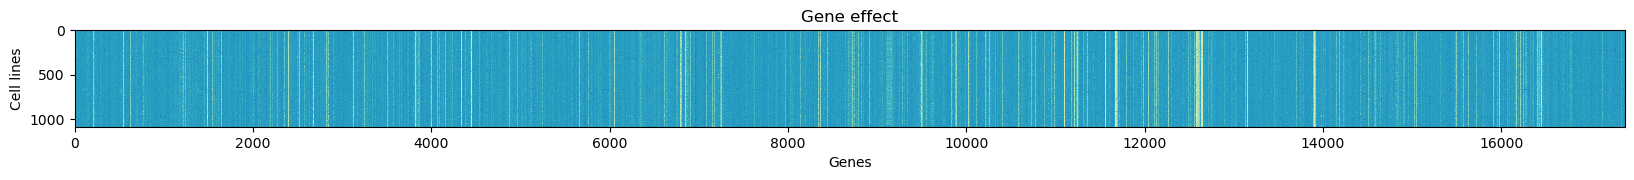

In [7]:
fig = plt.figure(figsize=(20,4))
plt.imshow(gene_effect.iloc[:,1:].fillna(0).to_numpy(), cmap="YlGnBu",interpolation='nearest')
plt.xlabel("Genes")
plt.ylabel("Cell lines")
plt.title("Gene effect")
plt.show()

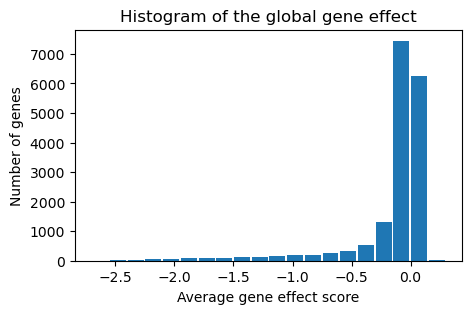

In [8]:
fig = plt.figure(figsize=(5,3))
plt.hist(gene_mean, rwidth=0.9, bins=20)
plt.xlabel('Average gene effect score')
plt.ylabel('Number of genes')
plt.title("Histogram of the global gene effect")
plt.show()

### CCLE_expression.csv

In [9]:
df = pd.read_csv('data/CCLE_expression.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Columns: 19222 entries, Unnamed: 0 to CDR1 (1038)
dtypes: float64(19221), object(1)
memory usage: 206.2+ MB


In [10]:
print(f"Gene expression goes from {df.iloc[:,1:].fillna(0).to_numpy().min():.2f} "
      f"to {df.iloc[:,1:].fillna(0).to_numpy().max():.2f}.")

Gene expression goes from 0.00 to 17.78.


In [11]:
gene_expression = df.rename(columns={"Unnamed: 0":"DepMap"}).set_index("DepMap")

In [12]:
print(f"Gene expression goes from {gene_expression.fillna(0).to_numpy().min():.2f} "
      f"to {gene_expression.fillna(0).to_numpy().max():.2f}.")

Gene expression goes from 0.00 to 17.78.


In [13]:
gene_expression.head(5)

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-001113,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,4.739848,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.0,0.275007,0.0,0.0,0.000000
ACH-001289,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,3.481557,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.0,0.014355,0.0,0.0,0.000000
ACH-001339,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,3.273516,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.0,0.084064,0.0,0.0,0.042644
ACH-001538,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,3.956986,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.0,0.028569,0.0,0.0,0.000000
ACH-000242,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,4.568032,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.0,0.464668,0.0,0.0,0.000000


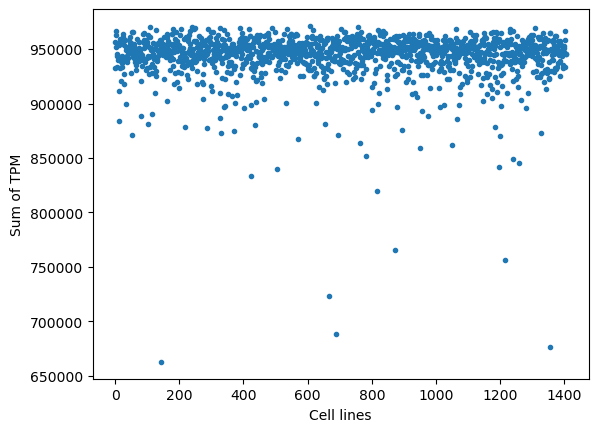

In [14]:
plt.plot((np.power(2,gene_expression.fillna(0).to_numpy()) - 1).sum(axis=1), ".")
plt.xlabel("Cell lines")
plt.ylabel("Sum of TPM")
plt.show()

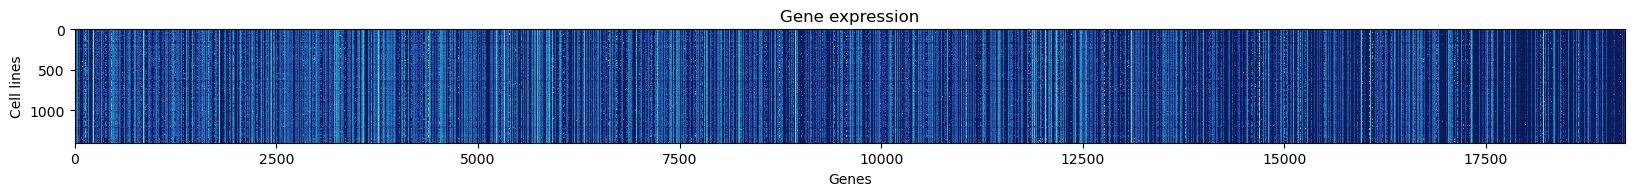

In [15]:
fig = plt.figure(figsize=(20,20))
plt.imshow(-gene_expression.fillna(0).to_numpy(), cmap="YlGnBu",interpolation='nearest')
plt.xlabel("Genes")
plt.ylabel("Cell lines")
plt.title("Gene expression")
plt.show()

In [16]:
gene_expr_mean = gene_expression.mean().to_numpy()

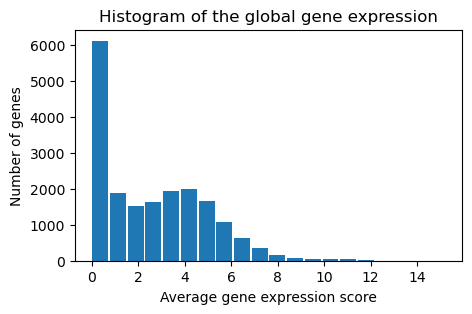

In [17]:
fig = plt.figure(figsize=(5,3))
plt.hist(gene_expr_mean, rwidth=0.9, bins=20)
plt.xlabel('Average gene expression score')
plt.ylabel('Number of genes')
plt.title("Histogram of the global gene expression")
plt.show()

### CRISPR_gene_dependency.csv

In [18]:
df = pd.read_csv('data/CRISPR_gene_dependency.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Columns: 17387 entries, DepMap_ID to ZZZ3 (26009)
dtypes: float64(17386), object(1)
memory usage: 144.1+ MB


In [19]:
gene_dependency = df

In [20]:
gene_dependency[:5]

,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000001,0.094568,0.012519,0.027460,0.025962,0.073412,0.027340,0.020199,0.284733,0.022084,...,0.037449,0.080585,0.034309,0.007142,0.004241,0.082956,0.012000,0.003592,0.012679,0.324623
1,ACH-000004,0.012676,0.049011,0.075933,0.033215,0.013176,0.097497,0.005015,0.153166,0.007358,...,0.038768,0.230569,0.007125,0.021209,0.011203,0.060266,0.128375,0.005911,0.004645,0.042530
2,ACH-000005,0.053957,0.027968,0.010139,0.005448,0.018599,0.081636,0.005457,0.159904,0.050884,...,0.017479,0.274568,0.054525,0.033396,0.033416,0.034712,0.092832,0.012482,0.020843,0.050412
3,ACH-000007,0.026704,0.083588,0.008853,0.011299,0.027288,0.028349,0.032573,0.166503,0.047045,...,0.196233,0.615338,0.011212,0.002200,0.005432,0.035241,0.138445,0.103161,0.146222,0.274833
4,ACH-000009,0.059383,0.051826,0.015370,0.011721,0.030062,0.078373,0.042128,0.184783,0.032335,...,0.152385,0.405712,0.029011,0.002816,0.056461,0.189550,0.328064,0.035161,0.058402,0.269194


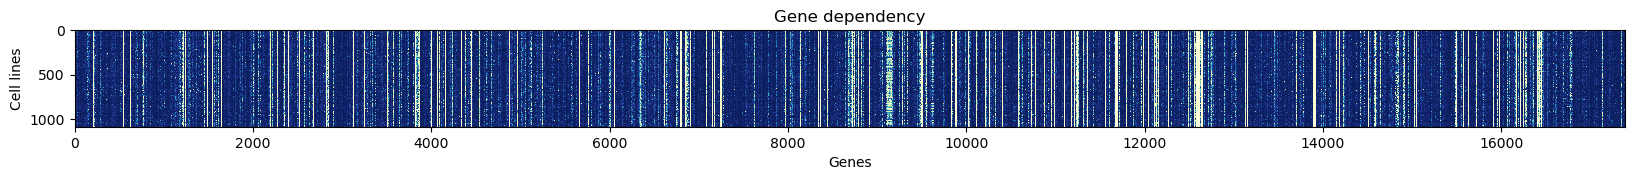

In [21]:
fig = plt.figure(figsize=(20,20))
plt.imshow(-gene_dependency.iloc[:,1:].fillna(0).to_numpy(), cmap="YlGnBu",interpolation='nearest')
plt.xlabel("Genes")
plt.ylabel("Cell lines")
plt.title("Gene dependency")
plt.show()

/var/folders/60/gqx458rj5xg861qqz_d5fpqm0000gn/T/ipykernel_32590/3860350178.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.hist(gene_dependency.mean().to_numpy(), rwidth=0.9, bins=20)


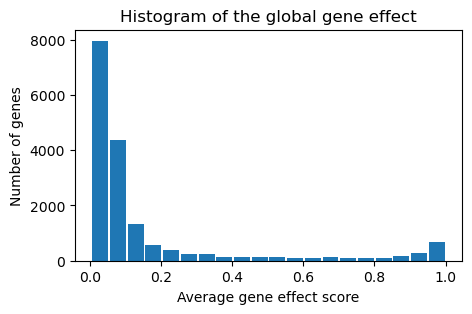

In [22]:
fig = plt.figure(figsize=(5,3))
plt.hist(gene_dependency.mean().to_numpy(), rwidth=0.9, bins=20)
plt.xlabel('Average gene effect score')
plt.ylabel('Number of genes')
plt.title("Histogram of the global gene effect")
plt.show()

### common_essentials.csv

In [23]:
df = pd.read_csv('data/common_essentials.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gene    1247 non-null   object
dtypes: object(1)
memory usage: 9.9+ KB


In [24]:
common_essentials = df.values[:,0].tolist()

In [25]:
common_essentials[:10]

['AAMP (14)',
 'AARS1 (16)',
 'AASDHPPT (60496)',
 'ABCB7 (22)',
 'ABCE1 (6059)',
 'ABCF1 (23)',
 'ABT1 (29777)',
 'ACO2 (50)',
 'ACTL6A (86)',
 'ACTR10 (55860)']

In [26]:
print(f"{len(set(gene_effect.columns[1:]).intersection(common_essentials))} " 
      f"essential genes out of "
      f"{len(common_essentials)} are in CRISPR dataset")

1237 essential genes out of 1247 are in CRISPR dataset


### nonessentials.csv

In [27]:
df = pd.read_csv('data/nonessentials.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gene    781 non-null    object
dtypes: object(1)
memory usage: 6.2+ KB


In [28]:
nonessentials = df.values[:,0].tolist()

In [29]:
nonessentials[:10]

['ABCG8 (64241)',
 'ACCSL (390110)',
 'ACTL7A (10881)',
 'ACTL7B (10880)',
 'ACTL9 (284382)',
 'ADAD1 (132612)',
 'ADAM18 (8749)',
 'ADAM2 (2515)',
 'ADAM20 (8748)',
 'ADAM30 (11085)']

In [30]:
print(f"{len(set(gene_effect.columns[1:]).intersection(nonessentials))} " 
      f"non-essential genes out of "
      f"{len(nonessentials)} are in CRISPR dataset")

632 non-essential genes out of 781 are in CRISPR dataset


In [31]:
len(gene_effect.columns[1:]) - 1237 - 632

15517

### Achilles_gene_effect.csv

In [32]:
df = pd.read_csv('data/Achilles_gene_effect.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Columns: 18018 entries, DepMap_ID to ZZZ3 (26009)
dtypes: float64(18017), object(1)
memory usage: 131.6+ MB


In [33]:
ach_gene_effect = df

In [34]:
gene_effect[:5]

,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000001,-0.134808,0.059764,-0.008665,-0.003572,-0.106211,-0.008257,0.018711,-0.291985,0.010921,...,-0.037619,-0.116524,-0.029331,0.105940,0.147605,-0.119822,0.063387,0.160857,0.058648,-0.316792
1,ACH-000004,0.081853,-0.056401,-0.106738,-0.014499,0.078209,-0.137562,0.168657,-0.198560,0.133372,...,-0.030901,-0.262220,0.136406,0.031327,0.093763,-0.079692,-0.173709,0.153632,0.175627,-0.040869
2,ACH-000005,-0.094196,-0.014598,0.100426,0.169103,0.032363,-0.148050,0.168931,-0.244777,-0.086871,...,0.039434,-0.336925,-0.095528,-0.035541,-0.035612,-0.040183,-0.165464,0.077343,0.019387,-0.085687
3,ACH-000007,-0.011544,-0.123189,0.080692,0.061046,-0.013454,-0.016922,-0.029474,-0.206516,-0.063998,...,-0.229303,-0.463191,0.061641,0.190301,0.119388,-0.036695,-0.182449,-0.146936,-0.189451,-0.281167
4,ACH-000009,-0.050782,-0.037466,0.068885,0.090375,0.012634,-0.079339,-0.017808,-0.183192,0.006227,...,-0.157219,-0.318765,0.015761,0.196949,-0.045874,-0.186805,-0.275629,-0.001227,-0.049140,-0.240582


In [35]:
ach_gene_effect[:10]

,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000004,0.101156,0.019349,-0.218404,-0.010704,0.146463,-0.142147,0.148280,-0.329886,0.158813,...,0.027789,-0.222223,0.028758,-0.042301,0.118614,-0.058945,-0.253932,0.195730,0.151277,-0.023335
1,ACH-000005,-0.028238,0.042131,0.004066,0.108121,0.111987,-0.137859,0.121038,-0.359282,-0.045626,...,0.080696,-0.272542,-0.251188,-0.133216,0.015223,-0.034227,-0.248819,0.097120,-0.025372,-0.091575
2,ACH-000007,0.017333,-0.078189,-0.014290,0.036944,0.025781,0.118371,-0.028417,-0.384452,-0.069142,...,-0.027712,-0.193231,0.021518,0.172009,0.176608,-0.052239,-0.205898,-0.132774,-0.284452,-0.292496
3,ACH-000009,0.010019,0.028949,-0.003500,-0.016936,0.175706,-0.068767,-0.003883,-0.500302,0.097460,...,-0.075284,-0.059321,-0.066400,0.143056,0.050993,-0.097471,-0.448131,0.112544,-0.024762,-0.324604
4,ACH-000011,0.148716,0.108353,0.020092,0.217960,0.039466,-0.178284,0.057066,-0.189037,0.118482,...,-0.427305,-0.369417,0.033576,0.125347,0.263868,0.192212,-0.110548,-0.002180,-0.108431,-0.087526
5,ACH-000012,-0.082635,0.117014,0.138791,0.209848,0.180846,-0.196354,0.204524,-0.272761,0.042582,...,-0.420747,-0.923473,-0.016314,-0.027456,0.114655,0.021571,-0.067376,-0.004093,-0.058754,-0.191354
6,ACH-000013,-0.015535,0.001449,-0.030753,0.092444,-0.011977,-0.071415,0.006707,-0.335956,-0.036073,...,0.028094,0.098388,-0.073535,-0.033270,0.168113,-0.008562,-0.086297,0.056528,-0.183953,-0.339958
7,ACH-000014,0.006573,0.010858,-0.013017,0.063485,0.051173,-0.108496,-0.224434,-0.250162,-0.130910,...,-0.138170,-0.769326,NaN,NaN,-0.091757,-0.021324,-0.034257,-0.187652,0.207787,-0.042954
8,ACH-000015,-0.146220,0.081580,-0.155090,0.035665,0.073600,-0.016473,0.112702,-0.388189,-0.002199,...,-0.149683,-0.155100,-0.064614,-0.016287,0.175737,0.051021,-0.100932,-0.026421,-0.207777,-0.100315
9,ACH-000017,0.061459,0.037299,-0.052803,0.019384,-0.195822,-0.101255,0.078690,-0.264971,-0.003009,...,-0.060247,-0.481306,-0.102695,0.167046,0.021319,-0.009194,-0.155613,0.100392,-0.208585,-0.206135


/var/folders/60/gqx458rj5xg861qqz_d5fpqm0000gn/T/ipykernel_32590/895493358.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.hist(gene_effect.mean().to_numpy(), rwidth=0.9, bins=20);plt.show()


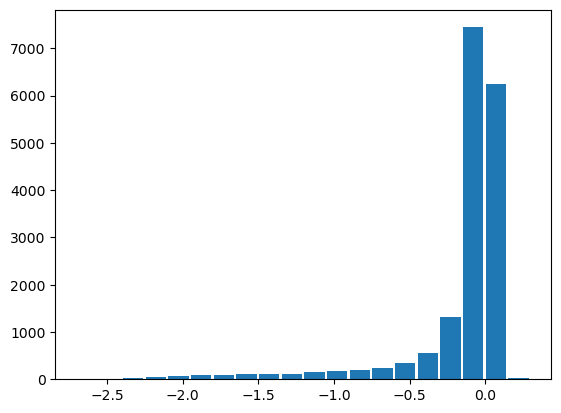

In [36]:
plt.hist(gene_effect.mean().to_numpy(), rwidth=0.9, bins=20);plt.show()

/var/folders/60/gqx458rj5xg861qqz_d5fpqm0000gn/T/ipykernel_32590/2609379372.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.hist(ach_gene_effect.mean().to_numpy(), rwidth=0.9, bins=20);plt.show()


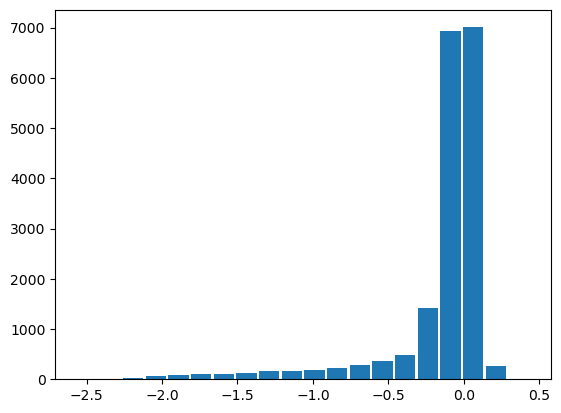

In [37]:
plt.hist(ach_gene_effect.mean().to_numpy(), rwidth=0.9, bins=20);plt.show()

### sample_info.csv

In [38]:
df = pd.read_csv('data/sample_info.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DepMap_ID                   1840 non-null   object 
 1   cell_line_name              1748 non-null   object 
 2   stripped_cell_line_name     1839 non-null   object 
 3   CCLE_Name                   1836 non-null   object 
 4   alias                       113 non-null    object 
 5   COSMICID                    981 non-null    float64
 6   sex                         1738 non-null   object 
 7   source                      1793 non-null   object 
 8   RRID                        1818 non-null   object 
 9   WTSI_Master_Cell_ID         980 non-null    float64
 10  sample_collection_site      1833 non-null   object 
 11  primary_or_metastasis       1198 non-null   object 
 12  primary_disease             1840 non-null   object 
 13  Subtype                     1696 

In [39]:
df.columns

Index(['DepMap_ID', 'cell_line_name', 'stripped_cell_line_name', 'CCLE_Name',
       'alias', 'COSMICID', 'sex', 'source', 'RRID', 'WTSI_Master_Cell_ID',
       'sample_collection_site', 'primary_or_metastasis', 'primary_disease',
       'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments',
       'lineage', 'lineage_subtype', 'lineage_sub_subtype',
       'lineage_molecular_subtype', 'default_growth_pattern',
       'model_manipulation', 'model_manipulation_details', 'patient_id',
       'parent_depmap_id', 'Cellosaurus_NCIt_disease', 'Cellosaurus_NCIt_id',
       'Cellosaurus_issues'],
      dtype='object')

In [40]:
cell_lines_info = df[['DepMap_ID', 'sample_collection_site', 'lineage', 'primary_disease']]

In [41]:
cell_lines_info.groupby('lineage').count()

,DepMap_ID,sample_collection_site,primary_disease
lineage,,,
adrenal_cortex,1,1,1
bile_duct,43,43,43
blood,141,141,141
bone,79,79,79
breast,86,86,86
central_nervous_system,109,107,109
cervix,24,24,24
colorectal,85,85,85
embryo,4,4,4


In [42]:
cell_lines_info.groupby('primary_disease')['lineage'].apply(lambda x: len(set(x)))

primary_disease
Adrenal Cancer                 1
Bile Duct Cancer               1
Bladder Cancer                 1
Bone Cancer                    1
Brain Cancer                   2
Breast Cancer                  1
Cervical Cancer                1
Colon/Colorectal Cancer        1
Embryonal Cancer               1
Endometrial/Uterine Cancer     1
Esophageal Cancer              1
Eye Cancer                     1
Gallbladder Cancer             1
Gastric Cancer                 1
Head and Neck Cancer           1
Kidney Cancer                  1
Leukemia                       1
Liposarcoma                    1
Liver Cancer                   1
Lung Cancer                    1
Lymphoma                       1
Myeloma                        1
Neuroblastoma                  1
Non-Cancerous                 10
Ovarian Cancer                 1
Pancreatic Cancer              1
Prostate Cancer                1
Rhabdoid                       2
Sarcoma                        3
Skin Cancer                

In [43]:
cell_lines_info.groupby('lineage').count().info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, adrenal_cortex to uterus
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   DepMap_ID               30 non-null     int64
 1   sample_collection_site  30 non-null     int64
 2   primary_disease         30 non-null     int64
dtypes: int64(3)
memory usage: 960.0+ bytes


**Retrieve Data**

In [44]:
df = pd.read_csv('data/CRISPR_gene_effect.csv')
gene_effect = df.rename(columns={"DepMap_ID":"DepMap"}).set_index("DepMap")

gene_effect.head(5)

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,-0.134808,0.059764,-0.008665,-0.003572,-0.106211,-0.008257,0.018711,-0.291985,0.010921,0.064932,...,-0.037619,-0.116524,-0.029331,0.105940,0.147605,-0.119822,0.063387,0.160857,0.058648,-0.316792
ACH-000004,0.081853,-0.056401,-0.106738,-0.014499,0.078209,-0.137562,0.168657,-0.198560,0.133372,0.151300,...,-0.030901,-0.262220,0.136406,0.031327,0.093763,-0.079692,-0.173709,0.153632,0.175627,-0.040869
ACH-000005,-0.094196,-0.014598,0.100426,0.169103,0.032363,-0.148050,0.168931,-0.244777,-0.086871,-0.036037,...,0.039434,-0.336925,-0.095528,-0.035541,-0.035612,-0.040183,-0.165464,0.077343,0.019387,-0.085687
ACH-000007,-0.011544,-0.123189,0.080692,0.061046,-0.013454,-0.016922,-0.029474,-0.206516,-0.063998,0.139288,...,-0.229303,-0.463191,0.061641,0.190301,0.119388,-0.036695,-0.182449,-0.146936,-0.189451,-0.281167
ACH-000009,-0.050782,-0.037466,0.068885,0.090375,0.012634,-0.079339,-0.017808,-0.183192,0.006227,-0.001700,...,-0.157219,-0.318765,0.015761,0.196949,-0.045874,-0.186805,-0.275629,-0.001227,-0.049140,-0.240582


In [45]:
df = pd.read_csv('data/CCLE_expression.csv')
gene_expression = df.rename(columns={"Unnamed: 0":"DepMap"}).set_index("DepMap")


gene_expression.head(5)

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-001113,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,4.739848,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.0,0.275007,0.0,0.0,0.000000
ACH-001289,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,3.481557,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.0,0.014355,0.0,0.0,0.000000
ACH-001339,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,3.273516,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.0,0.084064,0.0,0.0,0.042644
ACH-001538,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,3.956986,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.0,0.028569,0.0,0.0,0.000000
ACH-000242,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,4.568032,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.0,0.464668,0.0,0.0,0.000000


In [46]:
gene_expression = gene_expression.sort_values(by = 'DepMap').reindex(sorted(gene_expression.columns), axis = 1)
gene_effect = gene_effect.sort_values(by = 'DepMap').reindex(sorted(gene_effect.columns), axis = 1)

In [47]:
cols1 = gene_expression.columns
cols2 = gene_effect.columns

def intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

cols = sorted(intersection(cols1, cols2))
gene_expression = gene_expression[cols]
gene_effect = gene_effect[cols]

In [48]:
rows1 = list(gene_expression.index)
rows2 = list(gene_effect.index)

rows = intersection(rows1, rows2)
gene_expression = gene_expression.reindex(index = sorted(rows))
gene_effect = gene_effect.reindex(index = sorted(rows))

In [49]:
gene_expression.head()

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,3.116032,0.056584,0.226509,0.111031,0.000000,1.035624,0.176323,5.700440,4.144046,0.790772,...,5.080658,6.675957,0.978196,1.914565,4.700994,3.282440,2.797013,6.821455,3.010780,4.381975
ACH-000004,4.178715,0.000000,0.214125,0.344828,0.070389,0.097611,0.000000,6.336819,3.231125,0.000000,...,4.276497,6.098664,0.765535,1.622930,3.619413,0.014355,2.032101,7.002252,3.444932,4.910733
ACH-000005,4.003602,0.014355,0.137504,0.014355,0.000000,0.028569,0.000000,6.337176,3.781360,0.000000,...,5.628482,6.785289,0.807355,1.773996,3.763412,0.014355,2.761285,6.826421,3.524816,5.592457
ACH-000007,0.137504,1.405992,0.201634,0.000000,0.000000,0.014355,0.000000,5.431289,4.300856,3.547203,...,3.842979,6.125775,0.526069,1.761285,3.872829,0.014355,1.989139,6.332708,3.673556,3.469886
ACH-000009,1.464668,3.586164,0.250962,0.000000,0.042644,4.525443,0.000000,5.674122,4.510962,1.985500,...,4.761817,7.914086,0.815575,2.176323,3.773996,1.356144,2.956057,7.853185,3.442280,3.351911


In [50]:
gene_effect.head()

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,-0.134808,0.059764,-0.008665,-0.003572,-0.106211,-0.008257,0.018711,-0.291985,0.010921,0.064932,...,-0.037619,-0.116524,-0.029331,0.105940,0.147605,-0.119822,0.063387,0.160857,0.058648,-0.316792
ACH-000004,0.081853,-0.056401,-0.106738,-0.014499,0.078209,-0.137562,0.168657,-0.198560,0.133372,0.151300,...,-0.030901,-0.262220,0.136406,0.031327,0.093763,-0.079692,-0.173709,0.153632,0.175627,-0.040869
ACH-000005,-0.094196,-0.014598,0.100426,0.169103,0.032363,-0.148050,0.168931,-0.244777,-0.086871,-0.036037,...,0.039434,-0.336925,-0.095528,-0.035541,-0.035612,-0.040183,-0.165464,0.077343,0.019387,-0.085687
ACH-000007,-0.011544,-0.123189,0.080692,0.061046,-0.013454,-0.016922,-0.029474,-0.206516,-0.063998,0.139288,...,-0.229303,-0.463191,0.061641,0.190301,0.119388,-0.036695,-0.182449,-0.146936,-0.189451,-0.281167
ACH-000009,-0.050782,-0.037466,0.068885,0.090375,0.012634,-0.079339,-0.017808,-0.183192,0.006227,-0.001700,...,-0.157219,-0.318765,0.015761,0.196949,-0.045874,-0.186805,-0.275629,-0.001227,-0.049140,-0.240582


### ML

In [51]:
def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval() 

    losses = []
    accuracies = []

    for (x,y) in dataloader: # collection of tuples with iterator

        (x, y) = ( x.to(device), y.to(device) ) # transfer data to GPU

        output = model(x) # forward pass
        output = output.squeeze() # remove spurious channel dimension
        #loss = F.binary_cross_entropy_with_logits( output, y ) # numerically stable
        loss = F.mse_loss(output.float(), y.float())

        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        
    return np.mean(losses)

In [52]:
# TODO make wrapper function. 

def train_model(model, X_train, y_train, X_val, y_val, optimizer, device="cpu", batch_size = 5, 
                epochs=20, patience=10, verbose=True):
    """
    Train a 1D CNN model and record accuracy metrics.
    """

    # Make new Dataset and DataLoader objects for both training and validation data.
    train_dataset = data_utils.TensorDataset(X_train, y_train)
    train_dataloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = data_utils.TensorDataset(X_val, y_val)
    val_dataloader = data_utils.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Run the training loop with early stopping. 
    train_losses = []
    val_losses = []
    patience_counter = patience
    best_val_loss = np.inf
    check_point_filename = 'model_checkpoint.pt' # to save the best model fit to date
    for epoch in tqdm(range(epochs)):
        start_time = timeit.default_timer()
        train_loss = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss = run_one_epoch(False, val_dataloader, model, optimizer, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss: 
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
        elapsed = float(timeit.default_timer() - start_time)
        if verbose:
            print("Epoch %i | took %.2fs | Train loss: %.4f | Val loss: %.4f | Patience left: %i" % 
              (epoch+1, elapsed, train_loss, val_loss, patience_counter ))

    # Return the fitted model (not strictly necessary since this happens "in place"), train and validation accuracies.
    return model, train_losses, val_losses


In [53]:
class Net(torch.nn.Module):
    def __init__(self, input_size, output_size=None):
        super(Net, self).__init__()
        if output_size is None:
            output_size = input_size
        self.layer = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.layer(x.float())#type('TensorDloat'))      
        return x

In [54]:
device="cpu"

In [55]:
nb_genes = 5_000

In [56]:
model = Net(nb_genes).to(device)

In [57]:
X = gene_expression.dropna().iloc[:500,1:nb_genes + 1].to_numpy().astype('double')

In [58]:
y = gene_effect.dropna().iloc[:500,1:nb_genes + 1].to_numpy().astype('double')

In [59]:
def set_split(X, y, proportion):
    index = np.arange(len(X))
    np.random.shuffle(index)
    sum_p = sum(proportion)
    proportion = [p / sum_p for p in proportion]
    prop=0
    N = len(index)
    X_splits = []
    y_splits = []
    for i in range(len(proportion)):
        start_index = round( N*prop )
        end_index = round( N*(prop+proportion[i]) )
        
        set_index = index[start_index: end_index]
        X_splits.append( X[set_index] )
        y_splits.append( y[set_index] )
        
        prop += proportion[i]
    
    return *X_splits, *y_splits

In [60]:
X_train, X_val, X_test, y_train, y_val,y_test = set_split(X, y, [0.7,0.2,0.1])

In [61]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(350, 5000)
(350, 5000)
(100, 5000)
(100, 5000)
(50, 5000)
(50, 5000)


In [62]:
X_train = torch.tensor(X_train, device='cpu')
y_train = torch.tensor(y_train, device='cpu')
X_val = torch.tensor(X_val, device='cpu')
y_val = torch.tensor(y_val, device='cpu')
X_test = torch.tensor(X_test, device='cpu')
y_test = torch.tensor(y_test, device='cpu')

In [63]:
X_train.size()

torch.Size([350, 5000])

In [64]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [66]:
trained_model, train_losses, val_losses = train_model(model, X_train, y_train, X_val, y_val, 
                                                  optimizer,
                                                  device,
                                                 epochs=20,verbose=False)

In [ ]:
plt.plot(train_losses, label = "train")
plt.plot(val_losses, label = "validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()